In [1]:
import pickle

import numpy as np
import xarray as xr
import pandas as pd

from glob import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from metpy.units import units
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.calc import mixing_ratio_from_relative_humidity

from matplotlib.colors import BoundaryNorm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
slr_model_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/output/allsta_t_r_spd_swe_train1224/'

In [3]:
gfs = xr.open_dataset('/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/gfs/gfs_aggregate_all.nc')

# gfs = gfs[['t', 'r', 'spd']].isel(level=np.where((gfs.level <= 1000)&(gfs.level>=200))[0])

gfs['longitude'] = gfs['longitude'] - 360

gfs

<xarray.Dataset>
Dimensions:    (latitude: 81, level: 31, longitude: 121, time: 8879)
Coordinates:
  * level      (level) int64 1 2 3 5 7 10 20 30 ... 800 850 900 925 950 975 1000
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float64 -130.0 -129.8 -129.5 ... -100.5 -100.2 -100.0
  * time       (time) datetime64[ns] 2015-01-15T03:00:00 ... 2019-06-01
Data variables:
    gh         (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    pwat       (time, latitude, longitude) float32 ...
    orog       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    spd        (time, level, latitude, longitude) float32 ...
    dir        (time, level, latitude, longitude) float32 ...

In [205]:
obs_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/observations/'

interval = 24
site_list = ['CLN', 'AGD', 'ALTA', 'BCC', 'SLB', 'PVC', 'BSNFJE', 'BSNFDC', 'BSNFEX', 'CSSL',]
             
metadata = pd.read_excel(obs_dir + 'Dataset_Metadata.xlsx')
metadata = metadata[np.in1d(metadata['code'], site_list)].set_index('code')

data = []

for i, site in enumerate(site_list):
        
    site_metadata = metadata.loc[site, :]
    print('Working: ', site)
    
    baxter_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/baxter/'
    baxter = xr.open_dataset(baxter_path + 'baxter_climo.nc')
    baxter.sel()
    
    gfs_profile = gfs.sel(latitude=site_metadata['lat'], longitude=site_metadata['lon'], method='nearest')
    gfs_profile_df = pd.DataFrame()
    
    for data_var in gfs_profile.data_vars:
        
        if 'level' in gfs_profile[data_var].coords:
            
            for level in gfs_profile.level:

                newname = '%s%s'%(data_var.upper(), level.values)

#                 if data_var == 'r':
#                     p = level.values * units.millibar
#                     t = gfs_profile['t'].sel(level=level).values * units.kelvin
#                     r = gfs_profile[data_var].sel(level=level).values/100 * units.percent

#                     mixr = mixing_ratio_from_relative_humidity(r, t, p)
#                     q = specific_humidity_from_mixing_ratio(mixr)

#                     gfs_profile_df[newname.replace('R', 'Q')] = q

#                 else:
                gfs_profile_df[newname] = gfs_profile[data_var].sel(level=level)
        
        else:
            newname = data_var.upper()
            gfs_profile_df[newname] = gfs_profile[data_var]

        gfs_profile_df['time'] = gfs_profile.time
        gfs_profile_df = gfs_profile_df.set_index('time')
                
    f = glob('{}/clean/{}*.pd'.format(obs_dir, site))[0]
    site_data = pd.read_pickle(f)
    
    # Key match
    if 'slr'+str(interval) in str(site_data.keys):
        _interval = interval
    else:
        _interval = 24 if interval == 12 else 12 
    
    site_data = site_data.loc[:, [k for k in site_data.keys() if str(_interval) in k]]
    
    site_data = site_data.dropna()
    site_data = site_data[~site_data.index.duplicated(keep='first')]
    
    index = gfs_profile_df.index
    site_data = site_data.iloc[np.where(site_data.index > index[0])]

    gfs_profile_df_reduced = []
    tp_reduced = []
    
    tp = pd.DataFrame(gfs_profile_df.pop('TP'))

    for t in site_data.index:

        t0 = t-timedelta(hours=_interval-3)
        
        time_slice = gfs_profile_df.iloc[(np.where((index >= t0)&(index <= t)))].mean()
        time_slice['datetime_utc'] = t
        
        tp_time_slice = tp.iloc[(np.where((index >= t0)&(index <= t)))].sum()
        tp_time_slice['datetime_utc'] = t

        gfs_profile_df_reduced.append(pd.DataFrame(time_slice).T)
        tp_reduced.append(pd.DataFrame(tp_time_slice).T)

    gfs_profile_df = pd.concat(gfs_profile_df_reduced).set_index('datetime_utc').sort_index()
    tp_df = pd.concat(tp_reduced).set_index('datetime_utc').sort_index()
    
    gfs_profile_df.insert(0, 'swe_mm_model', tp_df)

    # Time match
    gfs_profile_df = gfs_profile_df[np.in1d(gfs_profile_df.index, site_data.index)]
    site_data = site_data[np.in1d(site_data.index, gfs_profile_df.index)]

    # Clean up
    gfs_profile_df = gfs_profile_df.loc[site_data[~site_data.duplicated()].index, :]
    site_data = site_data[~site_data.duplicated()]
    
    # Insert obs into profile
    for k in site_data.keys()[::-1]:
        gfs_profile_df.insert(0, k.replace('%d'%_interval, ''), site_data[k])

    gfs_profile_df = gfs_profile_df.dropna()
    gfs_profile_df.insert(0, 'site', np.full(gfs_profile_df.shape[0], fill_value=site))
    
    data.append(gfs_profile_df)
    del gfs_profile_df
    
data = pd.concat(data).reset_index()

time_id = data.pop('datetime_utc')
doy = np.array([t.strftime('%j') for t in time_id])

# Baxter here
baxter = xr.open_dataset(baxter_path + 'baxter_climo.nc')
bax_lat, bax_lon = baxter['lat'], baxter['lon']
site_lat, site_lon = site_metadata['lat'], site_metadata['lon']

a = abs(bax_lat-site_lat)+abs(bax_lon-site_lon)
i,j = np.unravel_index(a.argmin(),a.shape)

baxter_select = baxter.isel(y=i, x=j)

baxter_df = baxter_select.isel(time=doy.astype(int))['slr'].to_dataframe()
baxter_df = baxter_df.reset_index().drop(columns='time')

data['baxter_slr'] = baxter_df
#

swe_cutoff = 2.54 # 0.1"
data = data[data['swe_mm'] > swe_cutoff]

slr_cutoff_low = 1
data = data[data['slr'] >= slr_cutoff_low]

slr_cutoff_high = 50
data = data[data['slr'] <= slr_cutoff_high]

for k in ['depth_mm', 'snow_mm']:#, 'swe_mm']:
    try:
        data.pop(k)
    except:
        pass

def first(x):
    return x

def square(x):
    return x**2

def cube(x):
    return x**3

def inverse(x):
    return x**-1

transforms = [first, square, cube, inverse, np.log, np.exp, np.sqrt, np.cbrt]

color_id = data.pop('site')
reorder_slr = data.pop('slr')
data.insert(0, 'slr', reorder_slr)

# USE MODEL SWE
# print('used MODEL SWE')
# data.pop('swe_mm')
# data = data.rename(columns={'swe_mm_model':'swe_mm'})

data_new = pd.DataFrame()
for k in data.keys()[1:-1]:
    
    for transform in transforms:
        
        X = transform(data[k].astype(np.float64))
        
        if transform.__name__ == 'first':
            newname = k
        else:
            newname = k + '_' + transform.__name__
            
        data_new[newname] = X
        
data_new.insert(0, 'slr', data['slr'])
data_new.insert(1, 'baxter_slr', data['baxter_slr'])
data = data_new.reset_index().drop(columns='index')

data

Working:  CLN
Working:  AGD
Working:  ALTA
Working:  BCC
Working:  SLB
Working:  PVC
Working:  BSNFJE
Working:  BSNFDC
Working:  BSNFEX
Working:  CSSL


,slr,baxter_slr,swe_mm,swe_mm_square,swe_mm_cube,swe_mm_inverse,swe_mm_log,swe_mm_exp,swe_mm_sqrt,swe_mm_cbrt,...,DIR975_sqrt,DIR975_cbrt,DIR1000,DIR1000_square,DIR1000_cube,DIR1000_inverse,DIR1000_log,DIR1000_exp,DIR1000_sqrt,DIR1000_cbrt
0,4.000000,9.257324,12.70,161.289995,2.048383e+03,0.078740,2.541602,3.277478e+05,3.563706,2.333107,...,12.536633,5.396605,157.167175,24701.520990,3.882268e+06,0.006363,5.057310,1.806496e+68,12.536633,5.396605
1,8.700000,9.283203,5.84,34.105602,1.991767e+02,0.171233,1.764731,3.437794e+02,2.416609,1.800823,...,13.284580,5.609169,176.480057,31145.210435,5.496509e+06,0.005666,5.173208,4.408743e+76,13.284580,5.609169
2,15.390000,9.476562,3.30,10.890000,3.593700e+01,0.303030,1.193922,2.711264e+01,1.816590,1.488806,...,12.811428,5.475180,164.132690,26939.540068,4.421659e+06,0.006093,5.100675,1.913911e+71,12.811428,5.475180
3,14.290000,9.489502,7.11,50.552102,3.594255e+02,0.140647,1.961502,1.224148e+03,2.666458,1.922899,...,17.794729,6.815969,316.652374,100268.726129,3.175033e+07,0.003158,5.757805,3.314201e+137,17.794729,6.815969
4,6.890000,9.528076,7.37,54.316898,4.003155e+02,0.135685,1.997418,1.587634e+03,2.714774,1.946058,...,11.709913,5.156667,137.122070,18802.462167,2.578233e+06,0.007293,4.920872,3.559250e+59,11.709913,5.156667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,7.394366,6.000000,71.00,5041.000000,3.579110e+05,0.014085,4.262680,6.837671e+30,8.426150,4.140818,...,14.454268,5.933770,208.945892,43658.385923,9.122240e+06,0.004786,5.342075,5.546871e+90,14.454961,5.933960
1465,1.466667,6.000000,75.00,5625.000000,4.218750e+05,0.013333,4.317488,3.733242e+32,8.660254,4.217163,...,14.718994,6.006001,216.542450,46890.632631,1.015381e+07,0.004618,5.377787,1.104565e+94,14.715381,6.005018
1466,8.214286,6.000000,28.00,784.000000,2.195200e+04,0.035714,3.332205,1.446257e+12,5.291503,3.036589,...,14.969291,6.073898,224.055298,50200.776495,1.124775e+07,0.004463,5.411893,2.022924e+97,14.968477,6.073678
1467,11.428571,6.000000,28.00,784.000000,2.195200e+04,0.035714,3.332205,1.446257e+12,5.291503,3.036589,...,15.673342,6.262884,245.666092,60351.828719,1.482640e+07,0.004071,5.503973,4.913920e+106,15.673739,6.262990


In [206]:
output = data.copy()

output.insert(0, 'site', color_id)
output.insert(0, 'datetime_utc', time_id)

output = output[['site', 'datetime_utc', 'swe_mm', 'swe_mm_model', 'slr', ]]

output = output.rename(columns={
    'swe_mm':'observed_swe_mm',
    'swe_mm_model':'gfs_swe_mm',
    'slr':'observed_slr'})

output

,site,datetime_utc,observed_swe_mm,gfs_swe_mm,observed_slr
0,CLN,2016-10-30 21:00:00,12.70,2.020000,4.000000
1,CLN,2016-11-01 21:00:00,5.84,1.980000,8.700000
2,CLN,2016-11-16 21:00:00,3.30,0.000000,15.390000
3,CLN,2016-11-17 21:00:00,7.11,14.699999,14.290000
4,CLN,2016-11-20 21:00:00,7.37,0.040000,6.890000
...,...,...,...,...,...
1464,PVC,2019-02-11 00:00:00,71.00,42.875000,7.394366
1465,PVC,2019-02-13 09:00:00,75.00,3.437500,1.466667
1466,PVC,2019-02-13 23:00:00,28.00,119.937500,8.214286
1467,PVC,2019-02-14 09:00:00,28.00,15.687500,11.428571


In [207]:
def make_plot(_data, _slr, _model_type):
    
    _slr = _slr.dropna(how='any')
    _data = _data.loc[_slr.index]
    
    fig, axs = plt.subplots(1, 2, facecolor='w', figsize=(18, 8))

    ax = axs[0]
    for site, y_pred in _slr.groupby('site'):
        y_pred = y_pred['slr']
        y_true = _data['slr'].loc[_slr.index].loc[y_pred.index]
        ax.scatter(y_pred, y_true, edgecolor='k', linewidth=0.5, alpha=0.75, s=50, label=site)

    maxslr = 50
    ax.plot(np.arange(maxslr), np.arange(maxslr), 'k--')
    
    m, b = np.polyfit(_slr['slr'].values.astype(float), 
                      _data['slr'].values.astype(float), 1)
    bestfit = np.arange(0, maxslr+1, 1)
#     ax.plot((m*bestfit)+b, bestfit, 'r--', linewidth=2)

    ax.set_xlim([0, maxslr])
    ax.set_ylim([0, maxslr])

    ax.legend(fontsize=10, ncol=int(len(site_list)/2))
    ax.grid()

    ax = axs[1]

    bins = np.arange(0, 51, 2.5)
    heatmap, xedges, yedges = np.histogram2d(_data.loc[_slr.index]['slr'], _slr['slr'], bins=bins)
    cmap = plt.get_cmap('viridis')
    levels = [0, 1, 5, 10, 15, 20, 30, 40, 50]
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    for i, rowbin in enumerate(bins[1:]):
        
        fc_med = np.nanmedian(np.where((_data['slr'] > rowbin-2.5)&(_data['slr']<=rowbin), _slr['slr'], np.nan).astype(float))
        ob_med = np.nanmedian(np.where((_slr['slr'] > rowbin-2.5)&(_slr['slr']<=rowbin), _data['slr'], np.nan).astype(float))

        if ~np.isnan(fc_med):
            ax.scatter(np.searchsorted(bins, fc_med)+0.5, i+0.5, zorder=100, c='white', s=75, edgecolor='k')
            
        if ~np.isnan(ob_med):
            ax.scatter(i+0.5, np.searchsorted(bins, ob_med)+0.5, zorder=100, c='black', s=75, edgecolor='k')
            
    ax.scatter(0, 0, zorder=-1, c='white', s=75, edgecolor='k', label='Median Forecast Value')
    ax.scatter(0, 0, zorder=-1, c='black', s=75, edgecolor='k', label='Median Observed Value')
    ax.legend()

    cbd = ax.pcolormesh(heatmap, edgecolor='k', cmap=cmap, norm=norm, alpha=0.8)
    ax.set_xticks(range(len(xedges))[::2])
    ax.set_yticks(range(len(yedges))[::2])
    ax.plot(range(len(xedges)), range(len(yedges)), 'k--')
    ax.set_xticklabels(['%d'%x for x in xedges[::2]])
    ax.set_yticklabels(['%d'%x for x in yedges[::2]])
    plt.colorbar(cbd, label='\nn events')
    
    correlation_matrix = np.corrcoef(_slr['slr'].values.astype(float), _data['slr'].values.astype(float))
    correlation_xy = correlation_matrix[0,1]
    
    r_squared = correlation_xy**2
    mae = mean_absolute_error(_slr['slr'].values.astype(float), _data['slr'].values.astype(float))
    mse = mean_squared_error(_slr['slr'].values.astype(float), _data['slr'].values.astype(float))  
    mare = MARE(_data['slr'].values.astype(float), _slr['slr'].values.astype(float))
    
    ax.text(13, 20, 'R2: %.3f\nMAE: %.3f\nMSE: %.3f\nMARE: %.3f\n'%(
        #r2_score(_slr['slr'], _data.iloc[_slr.index]['slr']),
        r_squared, mae, mse, mare))

    for ax in axs:
        ax.set(aspect=1)
        ax.set_xlabel('\nForecast')
        ax.set_ylabel('Observed\n')

    plt.suptitle('GFS Application\n2015-2019 (n=%d)\nModel Type: %s\n'%(_slr.shape[0], _model_type.upper()))
    fig.subplots_adjust(top=0.8)
    plt.show()

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/output/allsta_t_r_spd_swe_train1224/linear_slr_model.npy


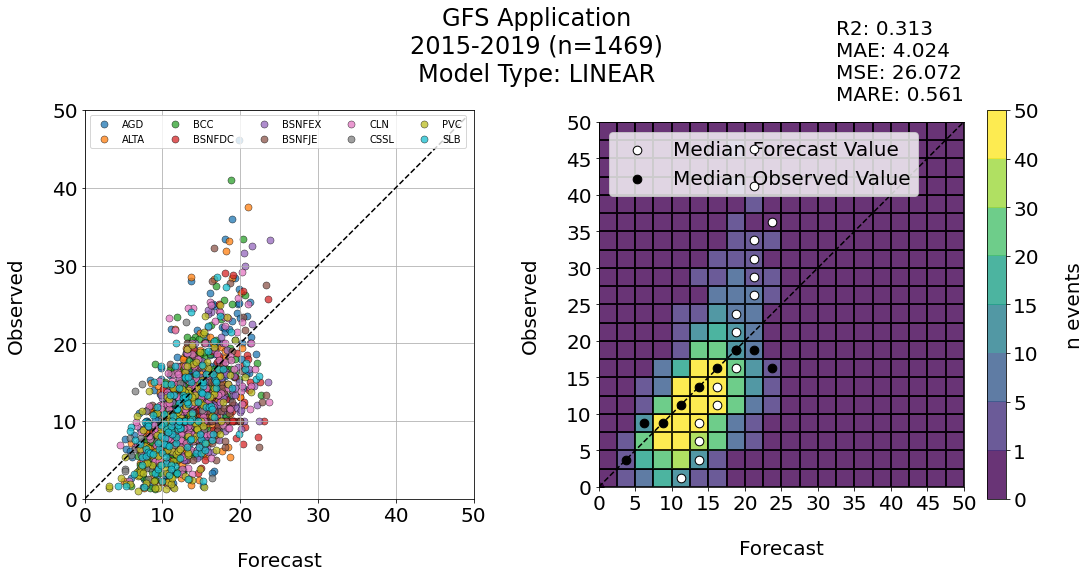

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/output/allsta_t_r_spd_swe_train1224/elastic_slr_model.npy


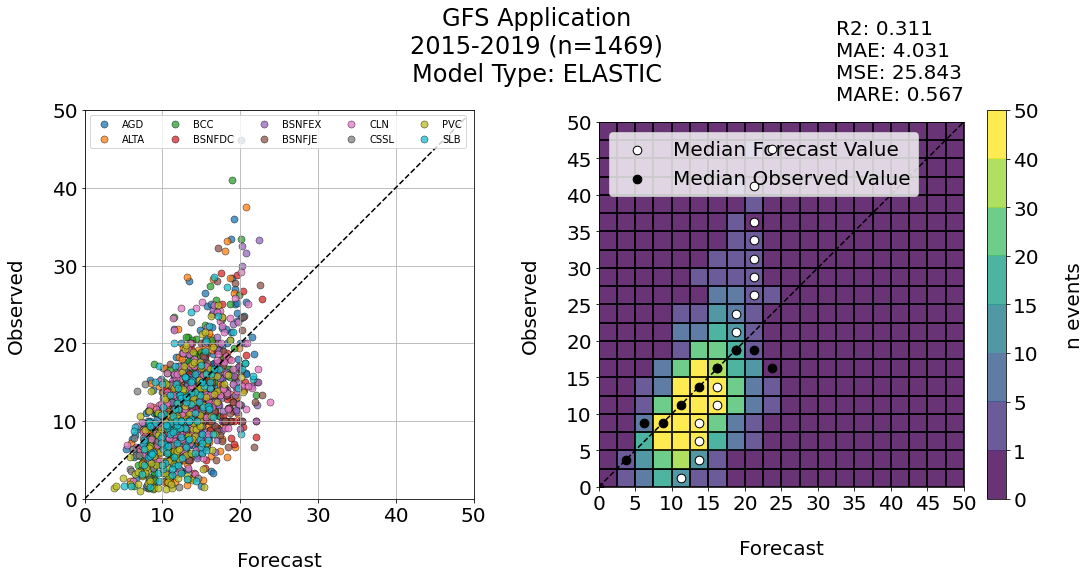

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/output/allsta_t_r_spd_swe_train1224/mlp_slr_model.npy


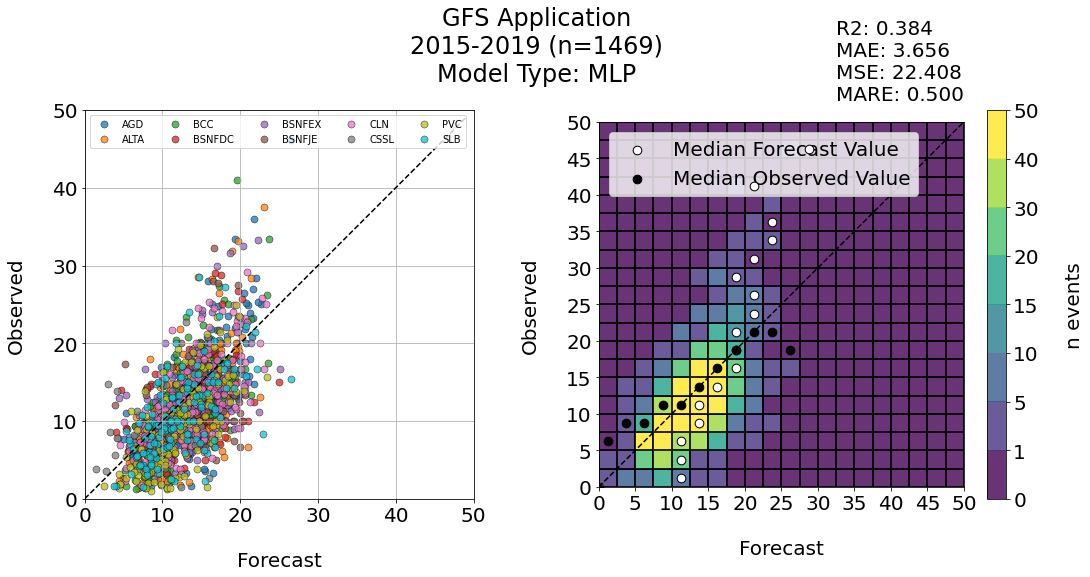

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/snow-liquid-ratio-final/output/allsta_t_r_spd_swe_train1224/SVR_slr_model.npy


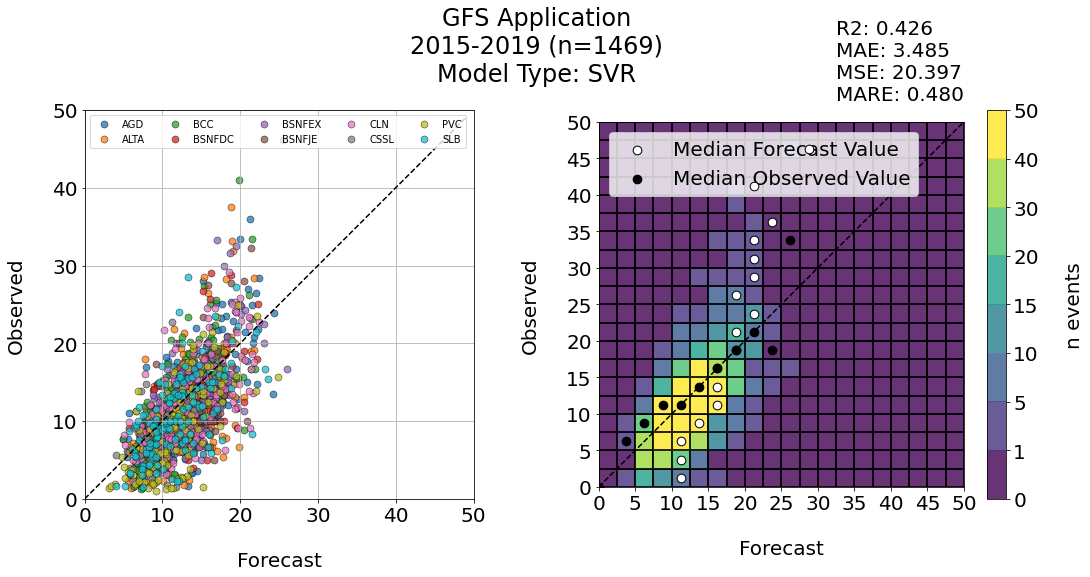

In [208]:
def svr_etc(_data, _model_type='SVR'):
    
    #'linear', 'elastic', 'mlp', 'SVR'
    model_file = slr_model_path + '%s_slr_model.npy'%_model_type
    key_file = slr_model_path + 'slr_model_keys.npy'
    scaler_file = slr_model_path + 'slr_model_scaler.npy'
    
    print(model_file)

    model = np.load(model_file, allow_pickle=True)[()]
    keys = np.load(key_file, allow_pickle=True)
    scaler = np.load(scaler_file, allow_pickle=True)[()]

    data_trim = _data.loc[:, keys]
    data_norm = pd.DataFrame(scaler.transform(data_trim), index=data_trim.index, columns=data_trim.keys())

    slr = model.predict(data_norm)
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])

    slr['slr'][slr['slr'] > 50] = np.nan
    slr['slr'][slr['slr'] < 0] = np.nan

    return slr

plt.rcParams.update({'font.size': 20})

for model_type in ['linear', 'elastic', 'mlp', 'SVR']:
    plot_slr = svr_etc(data, _model_type=model_type)  
    make_plot(data, plot_slr, _model_type=model_type)
    
    output.insert(output.shape[1], '%s_slr'%model_type.lower(), plot_slr['slr'])    

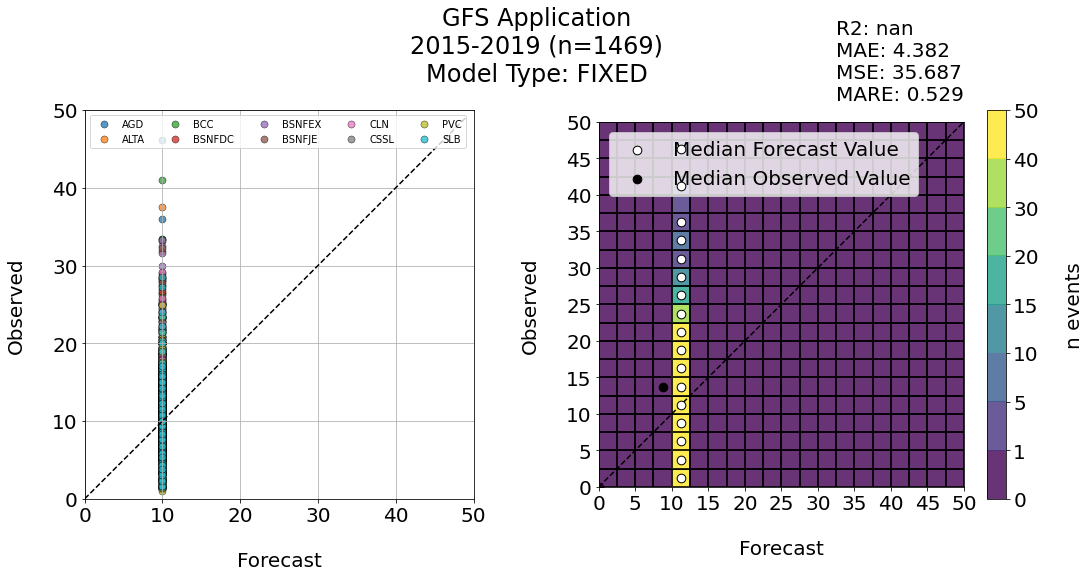

In [209]:
def ratio(X, fixed=10):
    
    slr = np.full(data.shape[0], fill_value=fixed)
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    
    return slr
    
plot_slr = ratio(data['slr'])
make_plot(data, plot_slr, 'fixed')
output.insert(output.shape[1], '%s_slr'%'fixed', plot_slr['slr'])    

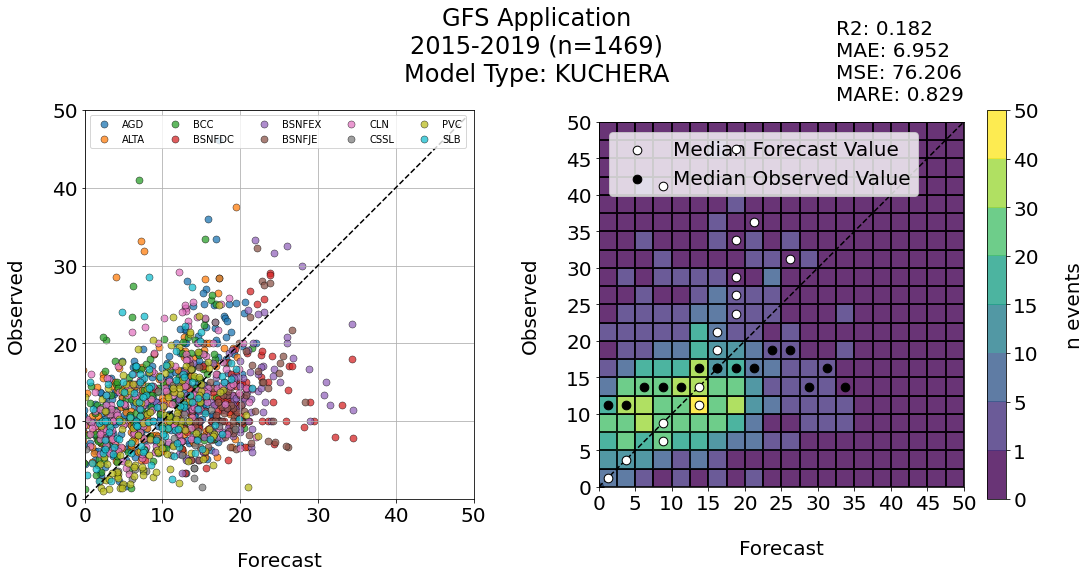

In [210]:
def kuchera(X, tvar='T800', units='K'):

    x = X[tvar]
    x = x if units == 'K' else x+273.15
        
    slr = np.where(x > 271.16, 12. + 2.*(271.16-x), 12 + (271.16-x))
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])

    return slr

plot_slr = kuchera(data)
make_plot(data, plot_slr, 'kuchera')
output.insert(output.shape[1], '%s_slr'%'kuchera', plot_slr['slr'])    

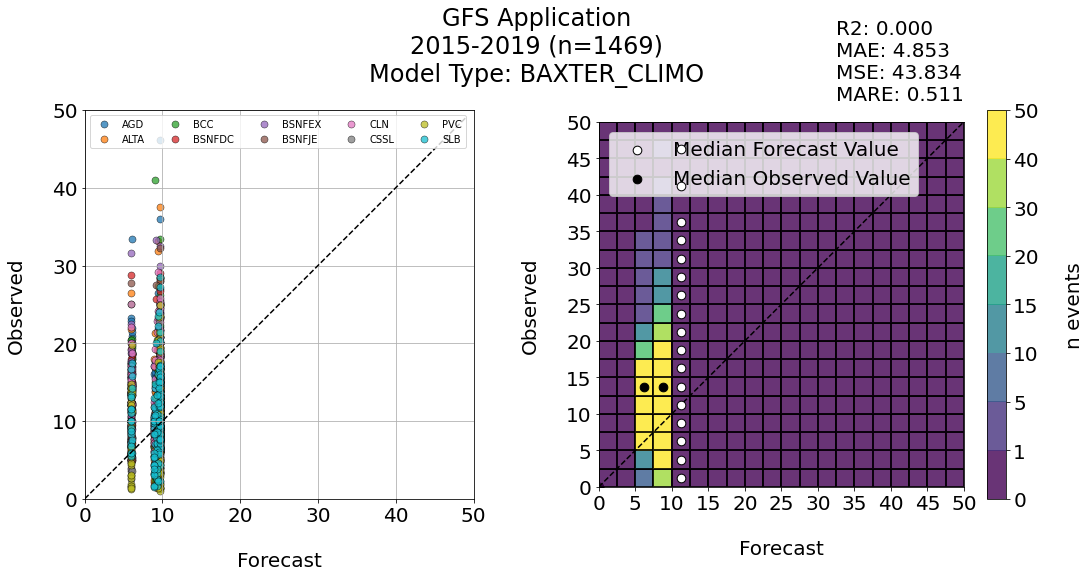

In [211]:
def baxter(X):
    slr = X['baxter_slr']
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    return slr

plot_slr = baxter(data)
make_plot(data, plot_slr, 'baxter_climo')
output.insert(output.shape[1], '%s_slr'%'baxter', plot_slr['slr'])    

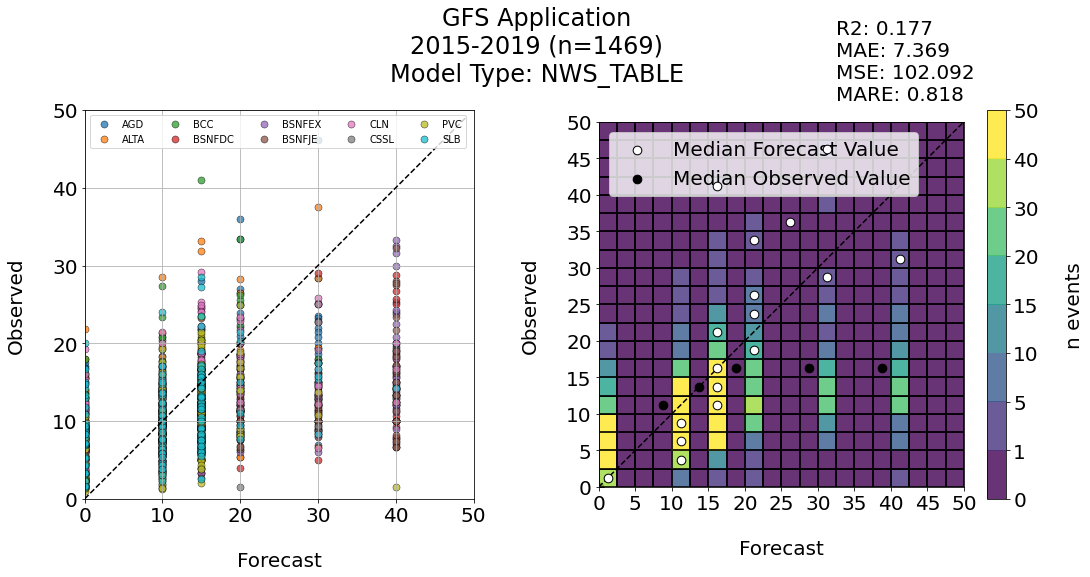

In [212]:
def nwstable(X, tvar='T750', units='K'):
    
    x = X[tvar]
    x = x if units == 'C' else x-273.15
    
    slr = []
    for _x in x:
        if _x > 1.5:
            slr.append(0)
        elif (-2.5 < _x <= 1.5):
            slr.append(10)
        elif (-7.5 < _x <= -2.5):
            slr.append(15)
        elif (-10 < _x <= -7.5):
            slr.append(20)
        elif (-12.5 < _x <= -10):
            slr.append(30)
        elif _x <= -12.5:
            slr.append(40)
        else:
            slr.append(np.nan)
        
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    return slr

plot_slr = nwstable(data)
make_plot(data, plot_slr, 'nws_table')
output.insert(output.shape[1], '%s_slr'%'nws_table', plot_slr['slr'])    

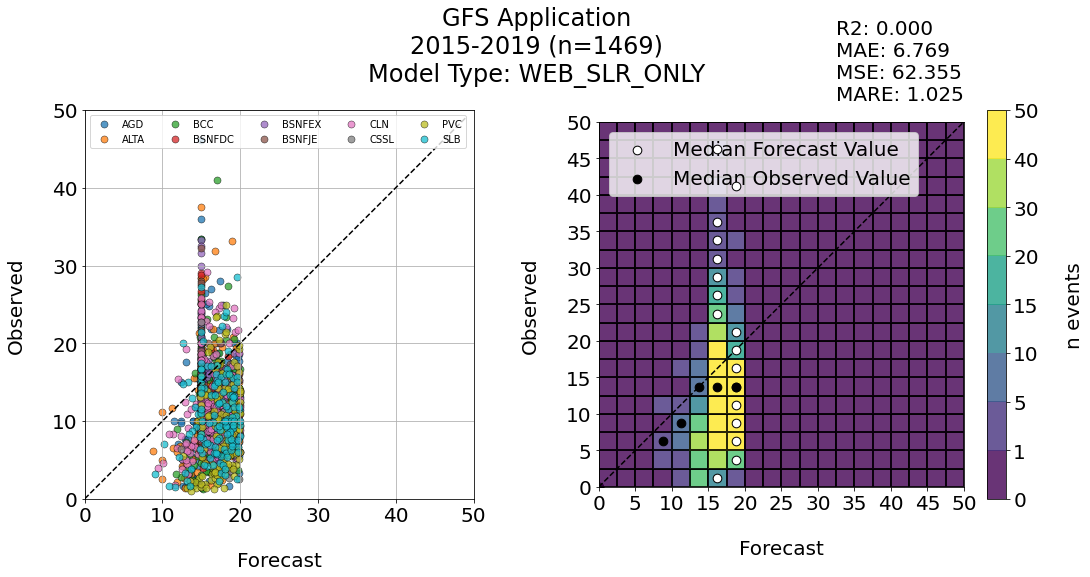

In [213]:
def web_slr_only(_X, wbzh=0, orog=0):
    
    slr = []
    for X in _X.iterrows():
        X = X[1]
    
        tlayer = np.mean([X['T400'], X['T500'], X['T600'], X['T700'], X['T800']])
        tlayer -= 273.15

        # Tunable transition layer parameters (m)
        all_snow_buffer = 0
        transition_layer = 200

        # Extend the snow level below the wet bulb zero parameter height if set
        snow_level = wbzh - all_snow_buffer
        snow_level = xr.where(snow_level < 0., 0., snow_level)

        # Curve fit to Alcott and Steenburgh (2010) SMLR results
        init_slr = xr.where(tlayer < 0., 5. - tlayer, 5.)
        init_slr = xr.where(tlayer < -15., 20. + (tlayer + 15.), init_slr)
        init_slr = xr.where(tlayer < -20., 15., init_slr)

        # Keep the initial SLR calculations above the snow level
        _slr = xr.where(orog >= snow_level, init_slr, 0.)

        # Linear attenuation of the SLR in the transition layer
        _slr = xr.where(
            ((orog < snow_level) & (orog > (snow_level - transition_layer))),
            (init_slr * (orog - (snow_level - transition_layer)) / transition_layer), _slr)
        
        slr.append(_slr)
        
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])

    return slr


plot_slr = web_slr_only(data)
make_plot(data, plot_slr, 'web_slr_only')
output.insert(output.shape[1], '%s_slr'%'web_slr', plot_slr['slr'])    

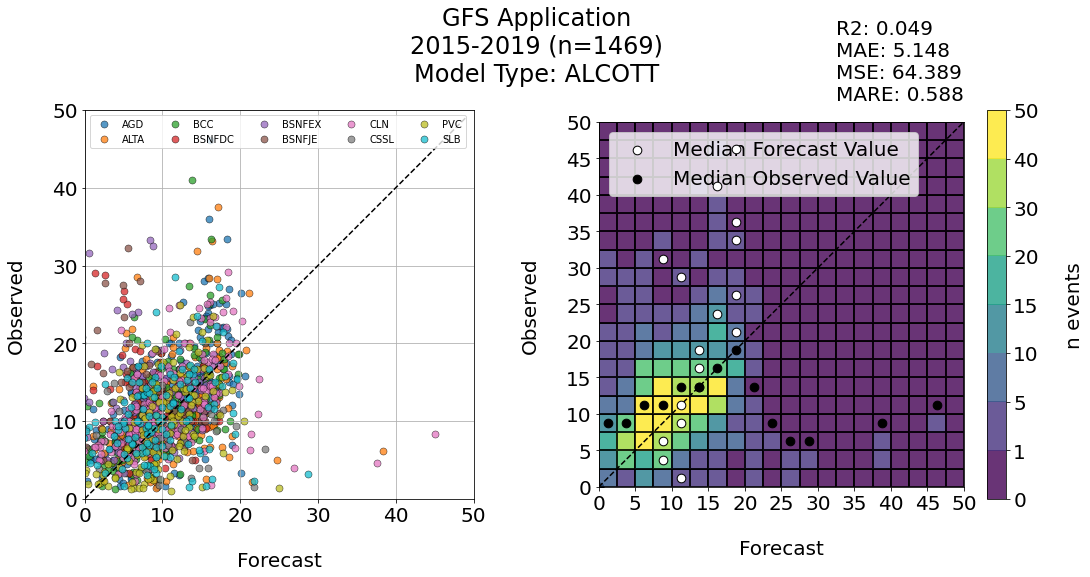

In [214]:
def alcott(_X):
    
    slr = []
    for X in _X.iterrows():
        X = X[1]
    
        predset = [
            [X['T650']-273.15, -3.31],
            [X['SPD600']**2, -1.73e-2],
            [X['swe_mm']/25.4, 1.26],
            [X['V400'], 5.91e-2],
            [(X['T600']-273.15)**3, 3.33e-3],
            [(X['T800']-273.15)**3, 4.38e-3],
            [1/(X['T600']-273.15), -243],
            [X['R550'], 6.16e-6], 
            [((X['R750'] + X['R700'])/2), -0.136],
            [X['R850'], 6.91e-6],
            [X['DIR700'], 1.27e-2],
            [abs(310.-X['DIR700']), 1.76e-2], # Direction index, a deviation from 310
            [(X['T500']-273.15)**2, 6.47e-2],
            [(X['T500']-273.15)**3, 2.16e-3],
            [(X['T550']-273.15)**3, -2.11e-3], 
            [X['SPD400'], -5.28e-2],
            [X['SPD600'], 0.342],]

        slr.append(np.sum([np.prod(i) for i in predset]))
        
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    slr['slr'] = slr['slr'] - 45

    return slr

plot_slr = alcott(data)
make_plot(data, plot_slr, 'alcott')
output.insert(output.shape[1], '%s_slr'%'alcott', plot_slr['slr'])    

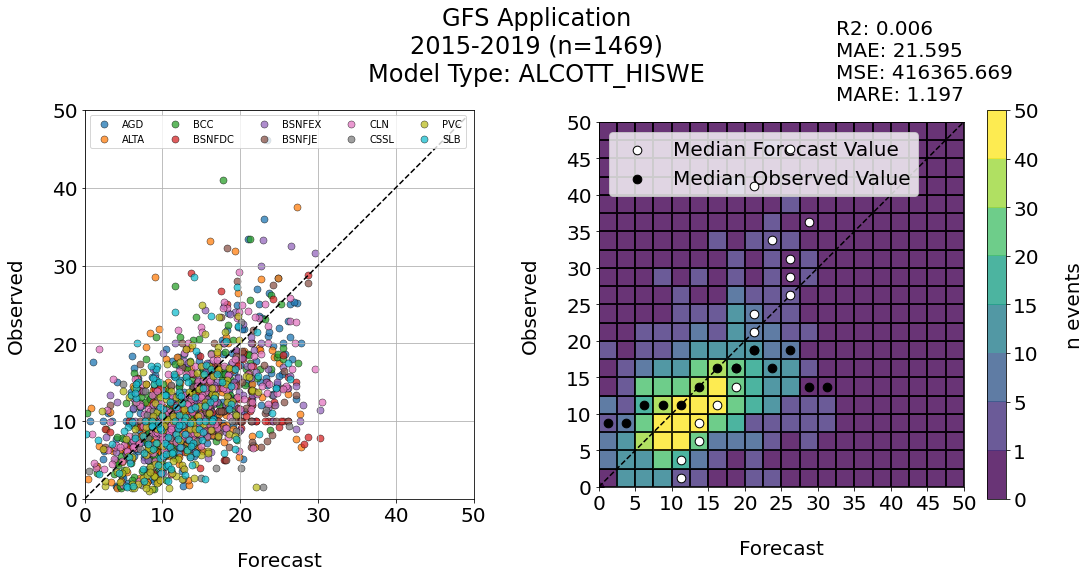

In [215]:
def alcott_hiswe(_X):
    
    slr = []
    for X in _X.iterrows():
        X = X[1]
    
        predset = [
            [(X['T550']-273.15), -0.489],
            [X['SPD600']**2, -1.61e-2],
            [((X['T750'] + X['T700'])/2)-273.15, -0.936],
            [X['V650'], 0.215],
            [X['T400']-273.15, 0.396],
            [1/(X['T850']-273.15), -0.151],
            [abs(310.-X['DIR850']), -2.05e-2],  # Direction indeX, a deviation from 310
            [X['R450'], 1.02e-5], 
            [((X['R850'] + X['R800'])/2), -3.76e-6]]

        slr.append(np.sum([np.prod(i) for i in predset]))
        
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    slr['slr'] = slr['slr']+20

    return slr

plot_slr = alcott_hiswe(data)
make_plot(data, plot_slr, 'alcott_hiswe')
output.insert(output.shape[1], '%s_slr'%'alcott_hiswe', plot_slr['slr'])    

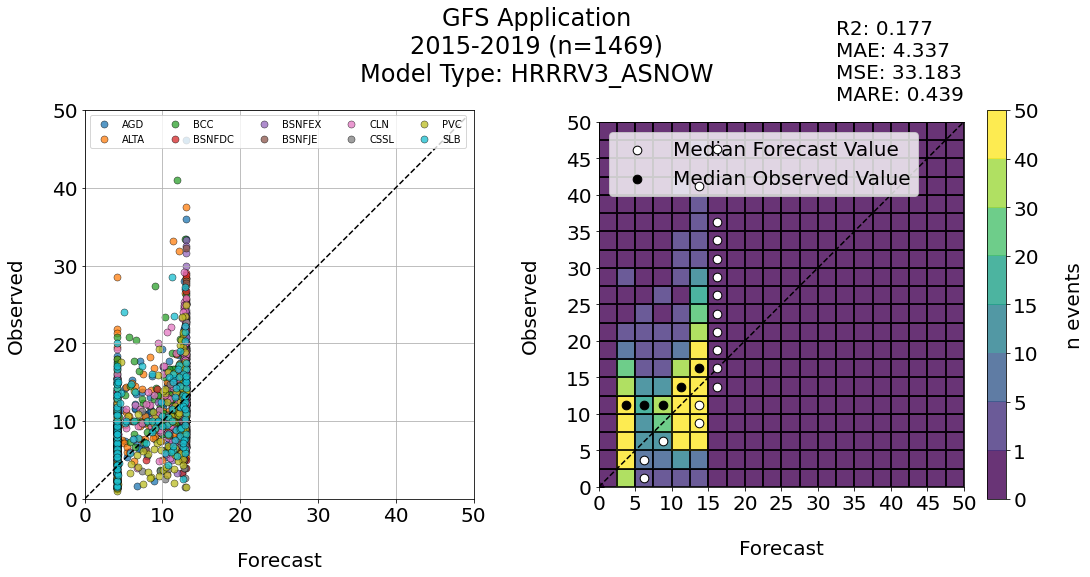

In [216]:
def hrrr_asnow(X, tvar='T750', units='K'):
    
    x = X[tvar]
    x = x if units == 'C' else x-273.15
    
    inner = (100. / np.where(4.179 > (13.*np.tanh((274.15-(x+273.15))/3.)),
        4.179, (13.*np.tanh((274.15-(x+273.15))/3.))))
    
    slr = (100 / np.where(250 < inner, 250, inner))
    
    slr = pd.DataFrame(np.array([slr, color_id]).T, columns=['slr', 'site'])
    
    return slr

plot_slr = hrrr_asnow(data)
make_plot(data, plot_slr, 'hrrrv3_asnow')
output.insert(output.shape[1], '%s_slr'%'hrrrv3_asnow', plot_slr['slr'])    

In [217]:
output = output.dropna(how='any').set_index(['site', 'datetime_utc'])

for k in output.keys():
    output[k] = output[k].astype(float).round(1)

output.to_csv('./slr_GFSverif_output.interval_%02dh.csv'%interval)
output

observed_swe_mm  gfs_swe_mm  observed_slr  \
site datetime_utc                                                     
CLN  2016-10-30 21:00:00             12.7         2.0           4.0   
     2016-11-01 21:00:00              5.8         2.0           8.7   
     2016-11-16 21:00:00              3.3         0.0          15.4   
     2016-11-17 21:00:00              7.1        14.7          14.3   
     2016-11-20 21:00:00              7.4         0.0           6.9   
...                                   ...         ...           ...   
PVC  2019-02-11 00:00:00             71.0        42.9           7.4   
     2019-02-13 09:00:00             75.0         3.4           1.5   
     2019-02-13 23:00:00             28.0       119.9           8.2   
     2019-02-14 09:00:00             28.0        15.7          11.4   
     2019-02-14 23:00:00            101.0        24.0           7.8   

                          linear_slr  elastic_slr  mlp_slr  svr_slr  \
site datetime_utc                                                     
CLN  2016-10-30 21:00:00         7.2          7.7      5.4      7.6   
     2016-11-01 21:00:00        13.4         13.0     11.6     12.7   
     2016-11-16 21:00:00        13.5         12.3     15.7     14.3   
     2016-11-17 21:00:00        14.6         15.0     14.4     13.6   
     2016-11-20 21:00:00        11.5         11.1     12.7     12.8   
...                              ...          ...      ...      ...   
PVC  2019-02-11 00:00:00         9.4          9.5      9.2      9.9   
     2019-02-13 09:00:00        11.4         12.1     12.4     11.8   
     2019-02-13 23:00:00         9.9         10.0      6.4      7.1   
     2019-02-14 09:00:00        15.1         15.1     12.2     14.1   
     2019-02-14 23:00:00         5.8          6.3      4.2      8.0   

                          fixed_slr  kuchera_slr  baxter_slr  nws_table_slr  \
site datetime_utc                                                             
CLN  2016-10-30 21:00:00       10.0        -14.2         9.3            0.0   
     2016-11-01 21:00:00       10.0         -3.9         9.3            0.0   
     2016-11-16 21:00:00       10.0         -8.9         9.5            0.0   
     2016-11-17 21:00:00       10.0         11.3         9.5           15.0   
     2016-11-20 21:00:00       10.0         -0.7         9.5            0.0   
...                             ...          ...         ...            ...   
PVC  2019-02-11 00:00:00       10.0          9.9         6.0           15.0   
     2019-02-13 09:00:00       10.0         15.1         6.0           20.0   
     2019-02-13 23:00:00       10.0          6.9         6.0           15.0   
     2019-02-14 09:00:00       10.0         16.2         6.0           20.0   
     2019-02-14 23:00:00       10.0          9.3         6.1           15.0   

                          web_slr_slr  alcott_slr  alcott_hiswe_slr  \
site datetime_utc                                                     
CLN  2016-10-30 21:00:00          9.5        27.0               1.4   
     2016-11-01 21:00:00         15.0         6.0               9.7   
     2016-11-16 21:00:00         12.0        22.4               3.7   
     2016-11-17 21:00:00         17.9        13.8              18.1   
     2016-11-20 21:00:00         13.9        11.1               5.0   
...                               ...         ...               ...   
PVC  2019-02-11 00:00:00         17.7        12.8              14.5   
     2019-02-13 09:00:00         15.0        21.8              22.9   
     2019-02-13 23:00:00         20.0         1.4               6.5   
     2019-02-14 09:00:00         15.0        17.7              23.3   
     2019-02-14 23:00:00         19.1         9.6               8.2   

                          hrrrv3_asnow_slr  
site datetime_utc                           
CLN  2016-10-30 21:00:00               4.2  
     2016-11-01 21:00:00               4.2  
     2016-11-16 21:00:00               4.2  
 